In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
import pandas as pd
from scipy.integrate import odeint

### Opening predator-prey dataset

In [8]:
df = pd.read_csv('predator-prey-data.csv', index_col=False)
df.head()


,Unnamed: 0,t,x,y
0,0,0.000000,4.781635,3.035257
1,1,0.202020,6.114005,2.189746
2,2,0.404040,6.238361,1.478907
3,3,0.606061,5.520524,0.989836
4,4,0.808081,4.582546,0.957827


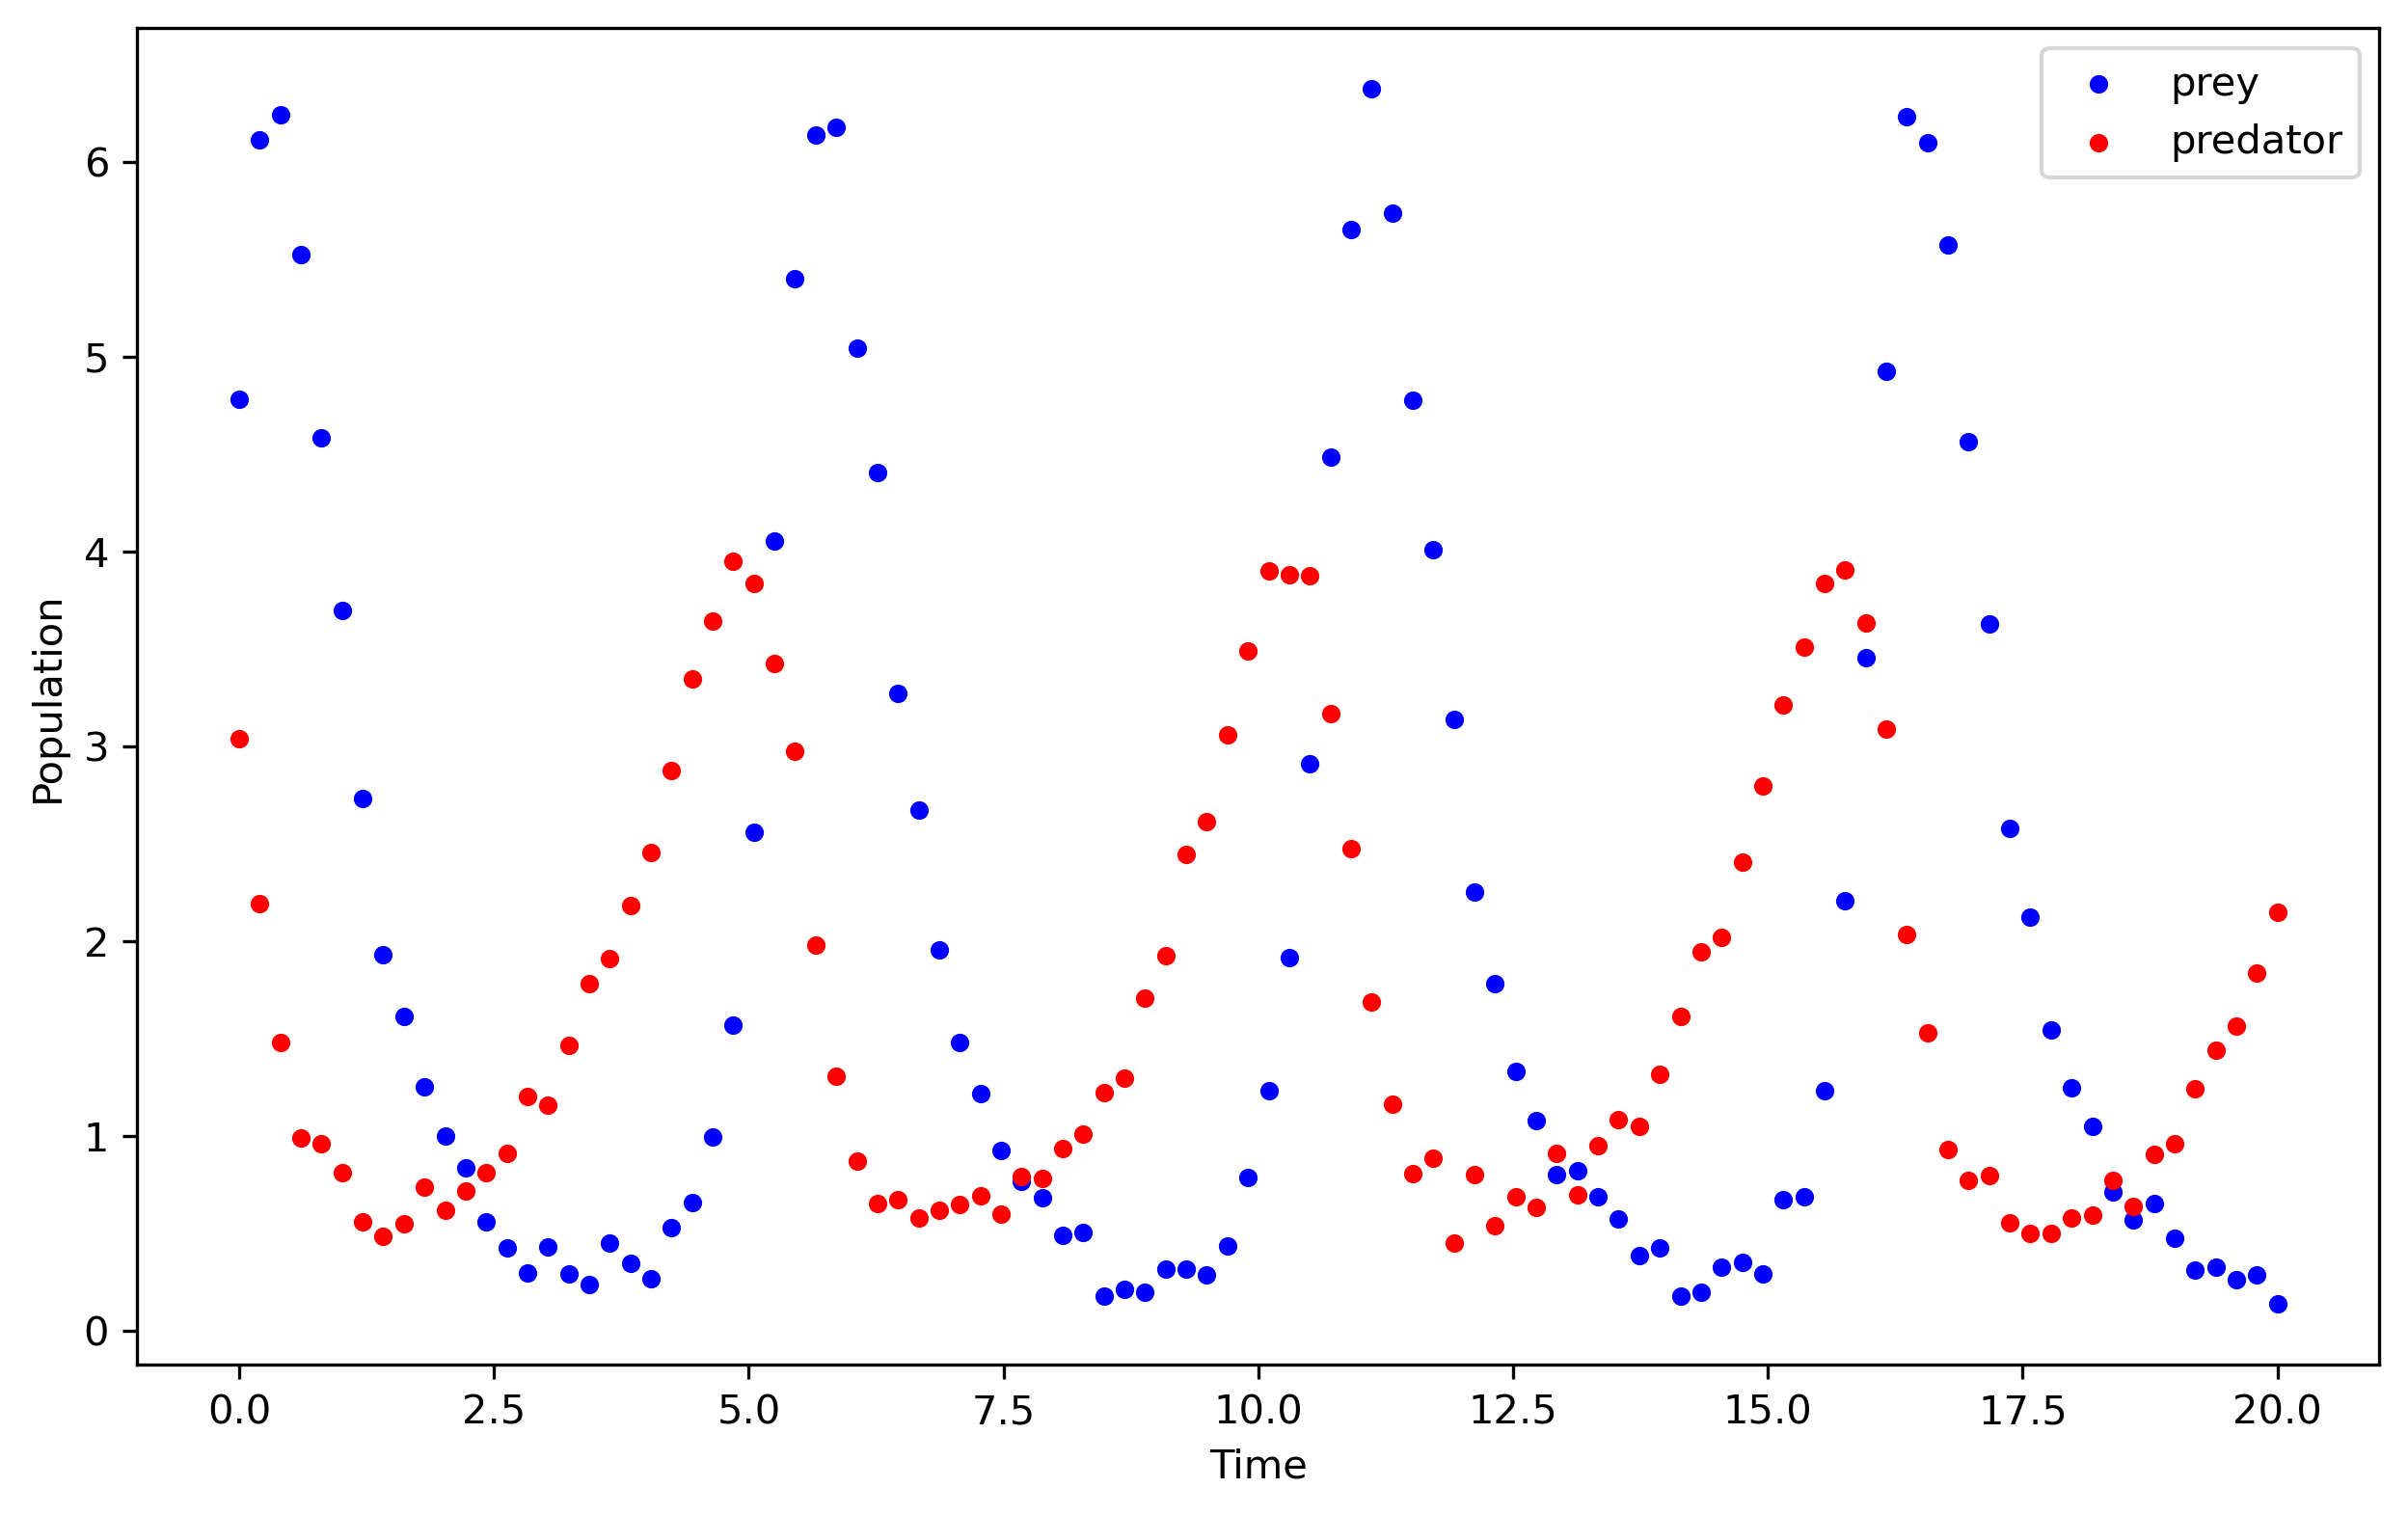

In [9]:
# Loading data into read-only numpy arrays
data = df[['t','x','y']].values
# data[1], data[2] = data[2].copy(), data[1].copy()
data.flags.writeable = False


# Plotting
plt.figure(dpi =300, figsize=(10, 6))
point_width = 13
# X should be prey
plt.scatter(data[:,0], data[:,1], label = 'prey', color = 'blue', s =point_width)
plt.scatter(data[:,0], data[:,2], label = 'predator', color = 'red', s=point_width)
plt.ylabel('Population')
plt.xlabel('Time')
plt.legend()


### Objective functions

#### Defining volterra equations function

In [10]:
def predator_prey_odes(initial_conditions,time ,alpha, beta, delta, gamma):
    x = initial_conditions[0]  # initial predator population
    y = initial_conditions[1]  # initial prey population
    dxdt = (alpha * x) - (beta * x * y)  # Predator ODE
    dydt = (delta * x * y) - (gamma * y)  # Predator ODE
    return [dxdt, dydt]

#Function that will return the data for predator and prey for a given set of parameters
def predator_prey_integration(time,initial_conditions,parameters): 
    alpha,beta,delta,gamma = parameters
    #odeint is now used as part of this function which returns the # of infected in the model
    results = odeint(predator_prey_odes,initial_conditions, time, args=(alpha,beta,delta,gamma)) 
    predator_values,prey_values = results[:,0], results[:,1]
    return np.array([predator_values,prey_values]).T

def hill_climbing(data, time, initial_conditions, parameters, objective, max_iterations=1000):
    '''Tries to find the best solution using random walker'''
    # Initialize starting parameter state
    scores = []
    x_n = parameters
    
    current_est = predator_prey_integration(time, initial_conditions, x_n)
    current_score = objective(data, current_est)
    scores.append(current_score)

    for _ in range(max_iterations):
        # Generate a random walk for parameters
        x_n_1 = random_walk(x_n)

        # Calculate the current and next estimations
        current_est = predator_prey_integration(time, initial_conditions, x_n)
        new_estimation = predator_prey_integration(time, initial_conditions, x_n_1)
        new_score = objective(data, new_estimation)

        # If the next estimation is better, update the parameters
        if new_score < current_score:
            current_score = new_score
            x_n = x_n_1
            scores.append(current_score)

    return x_n, scores

### Defining objective functions

In [15]:
# modulo linear error
def MSE(actual, predicted):
    '''Mean squared error'''
    return np.mean((actual - predicted)**2)

def MSE2(actual, predicted):
    '''Mean squared error, handles nan values'''
    x1, y1  = actual[:, 0], actual[:, 1]
    
    #Getting useful indexes
    indx_x = np.where(~np.isnan(x1))
    indx_y = np.where(~np.isnan(y1))
    x2, y2 = predicted[:, 0], predicted[:, 1]
    
    err1 = (x1[indx_x] - x2[indx_x])**2
    err2 = (y1[indx_y] - y2[indx_y])**2  
    
    return np.mean([err1,err2])


def MAE(actual, predicted):
    '''Calculate Mean Absolute Error (MAE) for multidimensional data.'''
    mae = np.mean(np.abs(actual - predicted))
    return mae

def MAE2(actual, predicted):
    '''Calculate Mean Absolute Error (MAE) for multidimensional data, handles nan values.'''
    x1, y1 = actual[:, 0], actual[:, 1]

    # Getting useful indexes
    indx_x = np.where(~np.isnan(x1))
    indx_y = np.where(~np.isnan(y1))
    
    x2, y2 = predicted[:, 0], predicted[:, 1]

    err1 = np.abs(x1[indx_x] - x2[indx_x])
    err2 = np.abs(y1[indx_y] - y2[indx_y])
    
    mae = np.mean([err1, err2])
    
    return mae

    

### Algorithms & Optimisation

In [16]:
         
def simulated_annealing(search_space,function,temp):
    scale = np.sqrt(temp) #Scaling factor for random movement. We square root the temperature to allow for a smoother decrease in scaling as the temperature decreases
    start = np.random.choice(search_space) #Start with a random x value 
    x = start * 1
    cur = function(x) #The function value of the current x solution
    history = [x] #Stores previously searched x values

    for i in range (1000):
        proposal = x + np.random.normal() * scale #A new solutiom is generated by adding a normally distributed random value to the current solution x
        delta = function(proposal) - cur

        if proposal < 0 or proposal > 1:
            proposal = x # Reject proposal if it is not in the correct range
    
        elif delta < 0:
            x = proposal ##Accept proposal

        elif np.exp(delta/temp) < np.random.rand(): #else if it is not negative (meaning it is a bad proposal), we may still accept it with the probability in the brackets, which depends on how high temp is
            x = proposal #Accept proposal

        cur = function(x)
        temp = 0.9 * temp #Cool temperature
        history.append(temp) #Add to history
    
    return x, history
        
        

In [17]:


def random_walk(parameters, variance = 1):
    lst = [parameter + np.random.normal(0, 1) for parameter in parameters]
    # Ensure all elements are positive
    while any(x <= 0 for x in lst):
        for indx in range(len(lst)):
            if lst[indx] <= 0:
                while lst[indx] < 0:
                    lst[indx] = parameters[indx] + np.random.normal(0, variance)
    return lst


def hill_climbing(data, time, initial_conditions, parameters, objective, max_iterations=1000, variance = 1):
    '''Tries to find the best solution using random walker'''
    # Initialize starting parameter state
    scores = []
    x_n = parameters
    all_scores = []
    
    current_est = predator_prey_integration(time, initial_conditions, x_n)
    current_score = objective(data, current_est)
    scores.append(current_score)

    for _ in range(max_iterations):
        # Generate a random walk for parameters
        x_n_1 = random_walk(x_n, variance)

        # Calculate the current and next estimations
        current_est = predator_prey_integration(time, initial_conditions, x_n)
        new_estimation = predator_prey_integration(time, initial_conditions, x_n_1)
        
        new_score = objective(data, new_estimation)

        # If the next estimation is better, update the parameters
        if new_score < current_score:
            current_score = new_score
            x_n = x_n_1
            scores.append(current_score)

    return x_n, scores


In [18]:
input_data = data[:,1:3]
# t = 
initial_conditions = [input_data[0][0], input_data[0][1]]

alpha = np.random.uniform(0.5, 2)
beta = np.random.uniform(0.5, 2)
delta = np.random.uniform(0.5, 2)
gamma = np.random.uniform(0.5, 2)
parameters = [alpha, beta, delta, gamma]

# Using MSEx
x_best, scores = hill_climbing(input_data, data[:,0], input_data[0], parameters, MAE, max_iterations=100, variance=1 )
print(x_best,scores)

[1.6252282439514079, 2.3097198583601175, 1.1371775956374999, 1.6779233030988905] [1.8309442625774255, 1.7316651864338821, 1.6155102266845314, 1.4710266545436101]


C:\Users\Aleks\AppData\Local\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


## Integrating function using found parameters

<Figure size 1000x800 with 0 Axes>

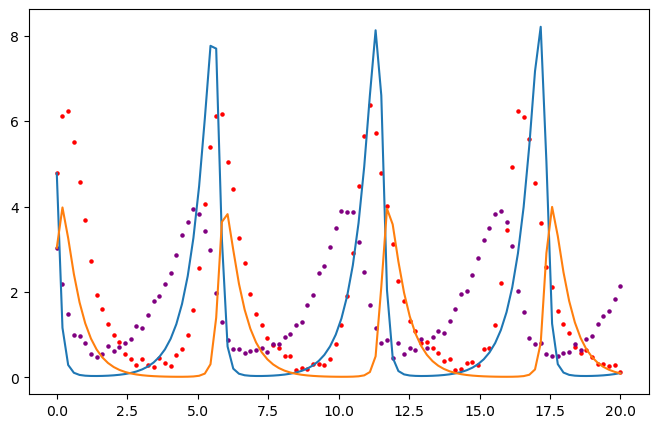

<Figure size 1000x800 with 0 Axes>

In [19]:
# t, x ,y = data
initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]

parameters = x_best

# Using MSE
x = predator_prey_integration(t,initial_conditions,parameters)

# Increase the figure size
plt.figure(figsize=(8, 5))  

plt.plot(t, x[:,0])
plt.plot(t, x[:,1])

plt.scatter(t, data[:,1], color= 'red', s =5)
plt.scatter(t, data[:,2], color= 'purple', s=5)

plt.figure(figsize=(10, 8))  

## Running simulation for different random walker variance

In [20]:
def uniform_draw_g(lower_bound, upper_bound):
    while True:
        yield np.random.uniform(lower_bound, upper_bound)

0
1
2


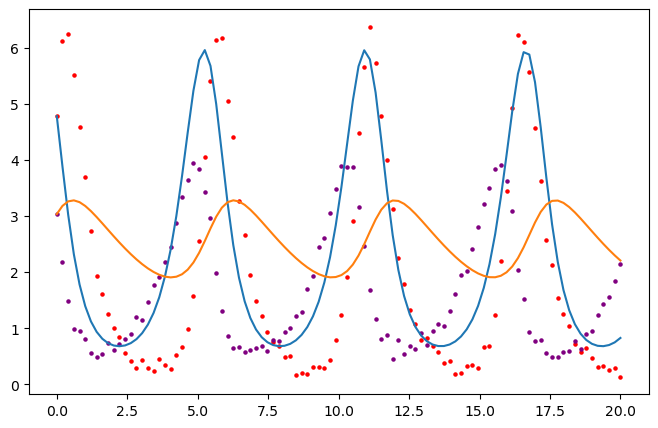

In [25]:
# Defining generators for variables
alpha = uniform_draw_g(0.5,2)
beta = uniform_draw_g(0.5,2)
delta = uniform_draw_g(0.5,2)
gamma = uniform_draw_g(0.5,2)

# Lists for storing values
parameter_list = [[],[],[]]
scores= [[],[],[]]
variances = [0.1,0.25,0.5]
best = []
best_score = float('inf')

# Running simulation for 
for k in range(len(variances)):
    print(k)
    for __ in range(100): 
        parameters = [next(alpha), next(beta), next(delta), next(gamma)]
        params, score = hill_climbing(input_data, data[:,0], input_data[0], parameters, MSE, max_iterations=100,variance=variances[k])
        parameter_list[k].append(params)
        scores[k].append(score)
        
        #Saving best parameter combination
        if score[-1] < best_score:
            best_score = score[-1]
            best = params
        scores[k].append(score)

parameter_list = np.array(parameter_list)
# PLOTTING

initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]

# Integrating with best guess
results = predator_prey_integration(t,initial_conditions,best)


# Increase the figure size
plt.figure(figsize=(8, 5))  

plt.plot(t, results[:,0])
plt.plot(t, results[:,1])

plt.scatter(t, data[:,1], color= 'red', s =5)
plt.scatter(t, data[:,2], color= 'purple', s=5)

plt.show()

# for x in scores:
#     plt.plot(x)
# plt.show()
# plt.figure(figsize=(10, 8)) 

# best_parameters = np.array(best_parameters)
# scores = np.array(scores)
 

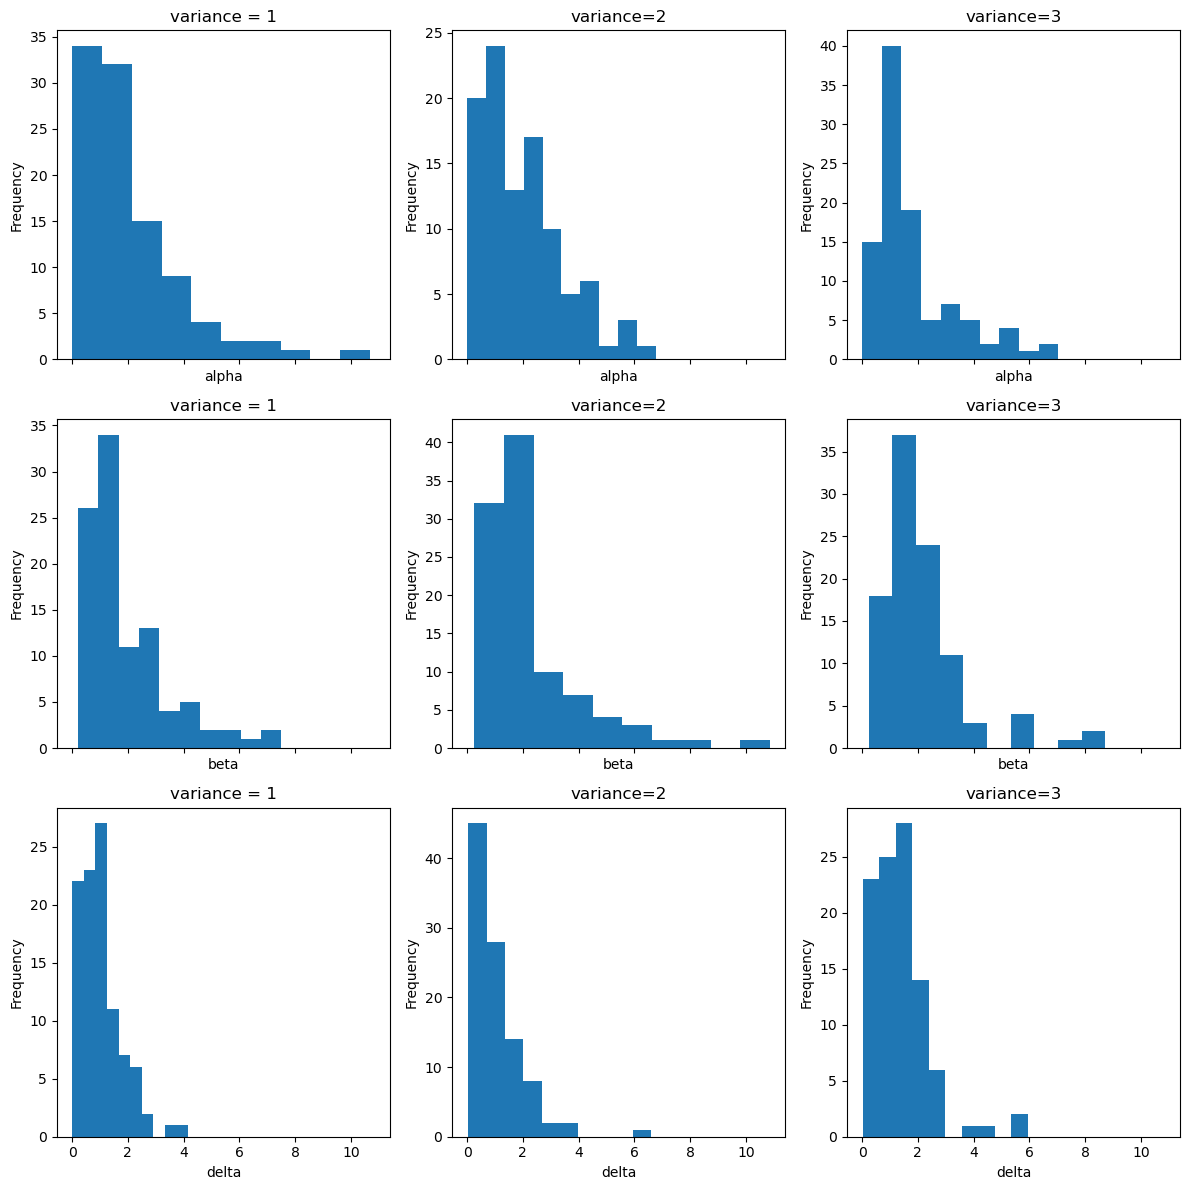

In [27]:

parameter_list = np.array(parameter_list)
# Create a figure with 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True)

# Plot histograms on each subplot using for loops with the same color
color = 'blue'
titles = ['variance = 0.1', 'variance=0.25', 'variance=0']
x_titles = ['alpha', 'beta', 'delta', 'omega']

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.hist(parameter_list[j][:,i])
        ax.set_xlabel(x_titles[i])
        ax.set_ylabel('Frequency')
        ax.set_title(titles[j])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


# Kaya's code section 

In [47]:
import statistics
import random 
import scipy.stats

def extrema_removal(time, input_data, points_removed, Focus = 'both'):
    prey = input_data.T[0]
    predator = input_data.T[1]
    
    # Calculate mean and variance to set regions for data
    mean_prey_population, mean_predator_population = np.mean(prey), np.mean(predator)
    variance_prey, variance_predator = statistics.variance(prey), statistics.variance(predator)
    
    # set upper bound and lower bound for point removals
    ub_prey, lb_prey = mean_prey_population + variance_prey, mean_prey_population - variance_prey
    ub_predator, lb_predator = mean_predator_population + variance_predator, mean_predator_population - variance_predator
    
    # initialize set up for removing points randomly given the bounds 
    prey_options = []
    predator_options = []
    # enumerate through list of stored points
    for index, prey_count in enumerate(prey):
        # check if they are in specified region
        if prey_count > ub_prey or prey_count < lb_prey:
            prey_options.append([index, prey_count, predator[index]])
    for index, predator_count in enumerate(predator):
        if predator_count > ub_predator or predator_count < lb_predator:
            predator_options.append([index, prey[index], predator_count])
    
    # remove points from list depending on which focus is set
    removal_options = []
    if Focus == 'both': 
        removal_options = removal_options + prey_options + predator_options
    elif Focus == 'prey':
        removal_options = removal_options + prey_options
    elif Focus == 'predator':
        removal_options = removal_options + predator_options
    else:
        print('Error: Removal option not known. Try either both, prey, or predator as an alternative.')
    
    # choose points to be removed randomly
    if points_removed > len(removal_options):
        points_removed = len(removal_options)
        print('WARNING: Maximum number of points that can be removed has been exceeded. All points possible within the given bound have now been removed.')
    removed_points_indices = random.choices(np.array(removal_options).T[0], k = points_removed)
    
    # turn the list into integers so we can remove them based on the indices
    integer_array = []
    for i in range(len(removed_points_indices)):
        integer_array.append(int(removed_points_indices[i]))
    
    # update the lists based on points we wanted to remove 
    mask_prey = np.ones(len(prey), dtype=bool)
    mask_prey[integer_array] = False
    updated_prey_data = prey[mask_prey] 
    
    mask_predator = np.ones(len(predator), dtype=bool)
    mask_predator[integer_array] = False
    updated_predator_data = predator[mask_predator]
    
    mask_time = np.ones(len(time), dtype=bool)
    mask_time[integer_array] = False
    updated_time_data = time[mask_time]
    
    return updated_time_data, updated_prey_data, updated_predator_data



yes
why


ValueError: The values in t must be monotonically increasing or monotonically decreasing; repeated values are allowed.

In [25]:
tt= float('inf')
if -2< tt:
    print('yes')

yes


### Random stuff
